# Sequel of _downsampling_mwe.ipynb
Applying tests to all columns

In [71]:
import pandas as pd
# get the data
# filepath = "data/2023_NCVR_Panse_1M/records.csv"
filepath = "data/2021_NCVR_Panse_001/dataset_ncvr_dirty.csv"
col_names = "sourceID,globalID,localID,FIRSTNAME,MIDDLENAME,LASTNAME,YEAROFBIRTH,PLACEOFBIRTH,COUNTRY,CITY,PLZ,STREET,GENDER,ETHNIC,RACE".split(",")
df = pd.read_csv(filepath, names=col_names, dtype={"PLZ": str, "YEAROFBIRTH": int},
                              keep_default_na=False)
df.head()

,sourceID,globalID,localID,FIRSTNAME,MIDDLENAME,LASTNAME,YEAROFBIRTH,PLACEOFBIRTH,COUNTRY,CITY,PLZ,STREET,GENDER,ETHNIC,RACE
0,A,AM28693,1fdc308dcc35344c6d5c20845fad641d,SUE,BARNES,SHUFFLER,1946,,BURKE,VALDESE,28690,LAKEVIEW ACRES,F,NL,W
1,A,CZ67291,b36b8c16c743ed415c6a7f3fc1a3b859,RONALD,EUGENE,LATTIMER,1953,OH,MOORE,PINEHURST,28374,BURNING TREE,M,NL,W
2,A,BN204837,401b7f6f5e107dbb009da197a2b05d9e,DEIDRE,MARLANA,MARTIN,1973,NC,FORSYTH,WINSTON SALEM,27105,CARVER GLEN,F,NL,B
3,A,EH737737,85f059d91b803b5835a8b9762a3170cb,KURT,,BALEN,1968,PA,WAKE,APEX,27502,ASHLEY DOWNS,M,NL,W
4,A,DT41462,f70a42ce915731cabafc5daa1bfbceeb,WORTH,BROWN,FOUTZ,1919,,ROWAN,SALISBURY,28146,MORRISON,M,NL,W


In [72]:
from scipy.stats import chisquare, entropy, spearmanr, anderson_ksamp
import matplotlib.pyplot as plt

In [73]:
def visual_comparison(e, o, show_index, file_name):
    e_scaled = e / float(sum(e)) * sum(o)
    print("--- Visual Comparison (equally scaled) ---")
    print("1. Plot both")
    for s in [e_scaled, o]:
        plt.scatter(x=s.index if show_index else range(s.shape[0]), y=s.tolist(), s=2)  # s = marker size
    plt.show()
    plt.savefig(f"plots/downsampling/{file_name}-plot-both")
    print("2. Plot total difference")
    diff = e_scaled.values - o.values
    plt.scatter(x=e.index if show_index else range(diff.shape[0]),
                y=diff, s=2)
    plt.show()
    plt.savefig(f"plots/downsampling/{file_name}-diff")
    print(f"3. mean diff = {diff.mean()} \n")
    print(f"4. Plot ratio e to o")
    ratio = e_scaled.values / o.values
    plt.scatter(x=e.index if show_index else range(ratio.shape[0]),
                y=ratio, s=2)
    plt.show()
    plt.savefig(f"plots/downsampling/{file_name}-ratio")

def chi(e, o):
    print("--- Chi Square GOF ---")
    print("(requires equal scaling)")
    e_scaled = e / float(sum(e)) * sum(o)
    p = chisquare(o, e_scaled)[1]
    print(f"p = {p}")
    print("different" if p < 0.05 else "same")
    print("\n")

def KLD(e, o):
    print("--- Kullback Leibler Divergence ---")
    print("(does not depend on scaling)")
    print(f"D = {entropy(e, o, 2)} \n")

def RCC(e, o):
    print("--- Rank Correlation Coefficient ---")
    print("(does not depend on scaling, only order)")
    res = spearmanr(e, o)
    print(res)
    print("same" if res.pvalue < 0.05 else "different")
    print("\n")

def make_all_tests(e, o, file_name):
    # filter the categories that are not in both datasets
    e = e[e.index.isin(o.index)]
    assert e.shape == o.shape
    print("### Sort by value ###")
    e = e.sort_values(ascending=False)
    o = o.sort_values(ascending=False)
    visual_comparison(e, o, show_index=False, file_name=file_name)
    chi(e, o)
    KLD(e, o)
    RCC(e, o)
    print("### Sort by Index ###")
    e = e.sort_index(ascending=False)
    o = o.sort_index(ascending=False)
    visual_comparison(e, o, show_index=e.index.shape[0]<200, file_name=file_name)
    chi(e, o)
    KLD(e, o)
    RCC(e, o)

In [74]:
from random_sample import random_sample_wrapper

df_res = random_sample_wrapper(df, 50_000, seed=43)

In [75]:
e = df.FIRSTNAME.value_counts().sort_values(ascending=False)
o = df_res.FIRSTNAME.value_counts().sort_values(ascending=False)

### Sort by value ###
--- Visual Comparison (equally scaled) ---
1. Plot both


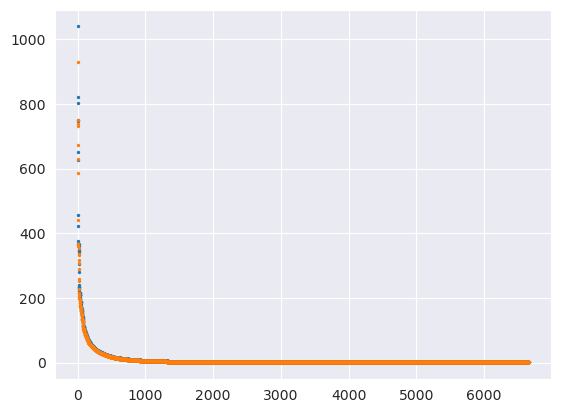

2. Plot total difference


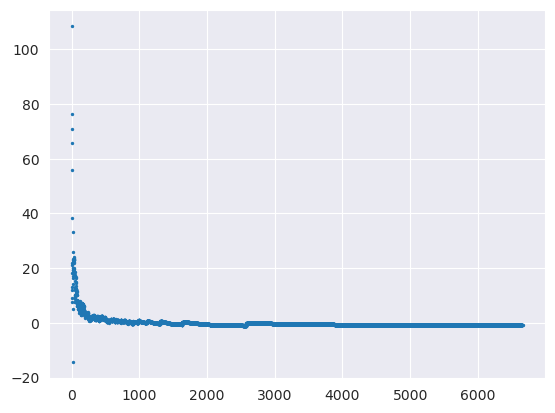

3. mean diff = 6.82803830159856e-17 

4. Plot ratio e to o


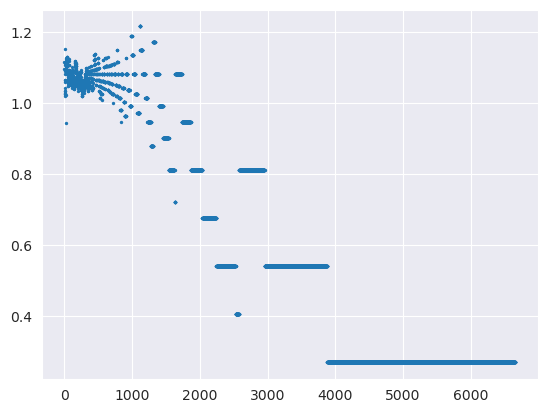

--- Chi Square GOF ---
(requires equal scaling)
p = 0.8744141063345868
same


--- Kullback Leibler Divergence ---
(does not depend on scaling)
D = 0.0416294517261028 

--- Rank Correlation Coefficient ---
(does not depend on scaling, only order)
SpearmanrResult(correlation=0.9097730975031331, pvalue=0.0)
same


### Sort by Index ###
--- Visual Comparison (equally scaled) ---
1. Plot both


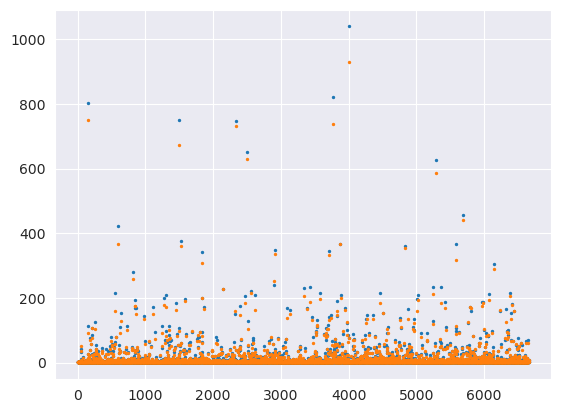

2. Plot total difference


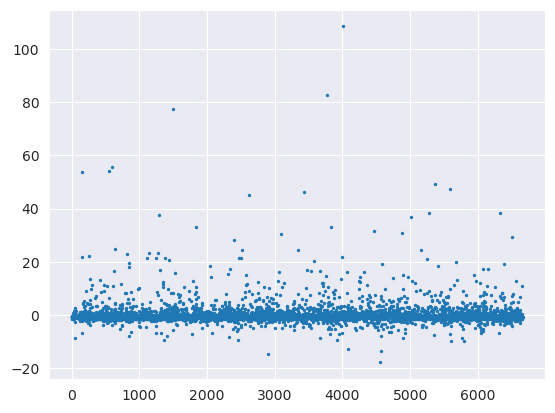

3. mean diff = 3.200642953874325e-17 

4. Plot ratio e to o


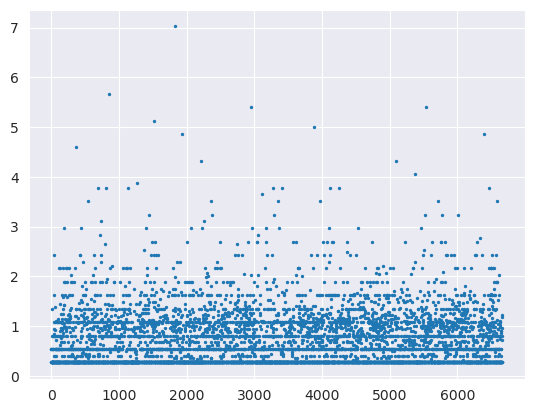

--- Chi Square GOF ---
(requires equal scaling)
p = 1.3508318043425764e-121
different


--- Kullback Leibler Divergence ---
(does not depend on scaling)
D = 0.0755827227489602 

--- Rank Correlation Coefficient ---
(does not depend on scaling, only order)
SpearmanrResult(correlation=0.8261581148847494, pvalue=0.0)
same




<Figure size 640x480 with 0 Axes>

In [76]:
make_all_tests(e, o, "FIRSTNAME")

### Sort by value ###
--- Visual Comparison (equally scaled) ---
1. Plot both


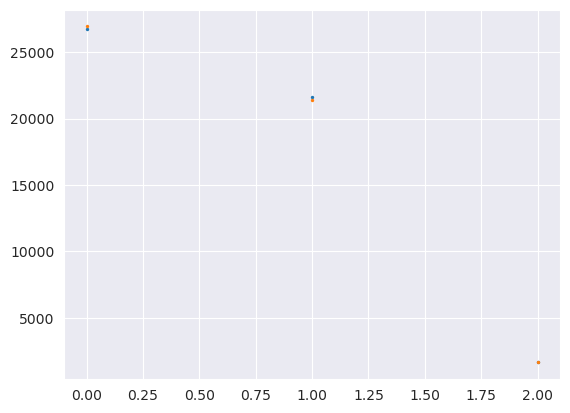

2. Plot total difference


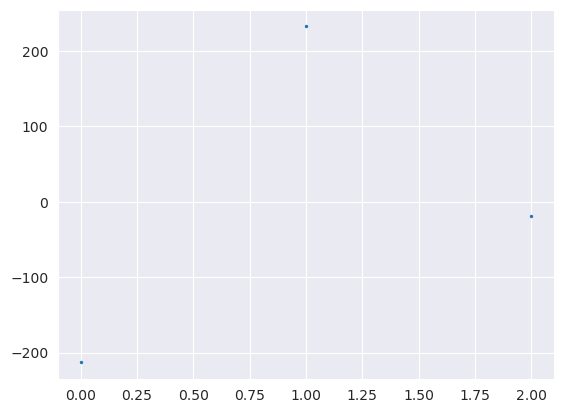

3. mean diff = 7.579122514774402e-14 

4. Plot ratio e to o


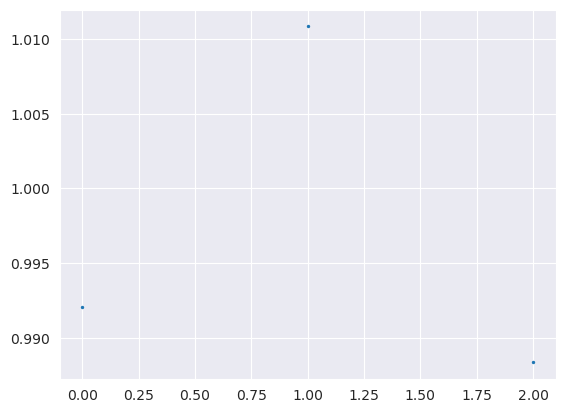

--- Chi Square GOF ---
(requires equal scaling)
p = 0.10989880648908612
same


--- Kullback Leibler Divergence ---
(does not depend on scaling)
D = 6.381922810710117e-05 

--- Rank Correlation Coefficient ---
(does not depend on scaling, only order)
SpearmanrResult(correlation=1.0, pvalue=0.0)
same


### Sort by Index ###
--- Visual Comparison (equally scaled) ---
1. Plot both


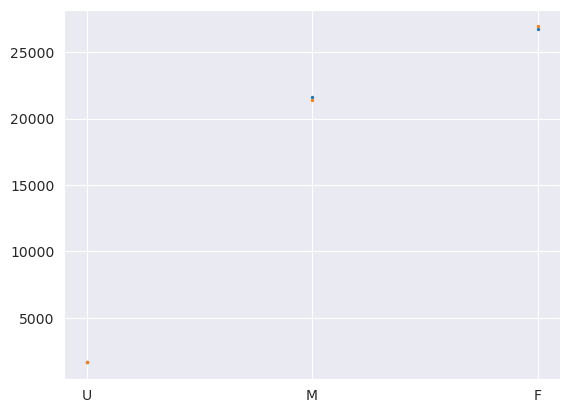

2. Plot total difference


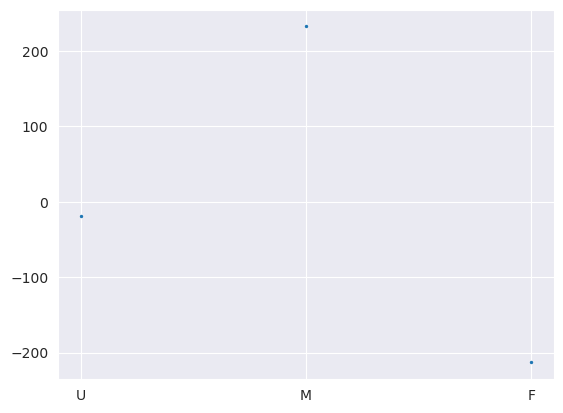

3. mean diff = 7.579122514774402e-14 

4. Plot ratio e to o


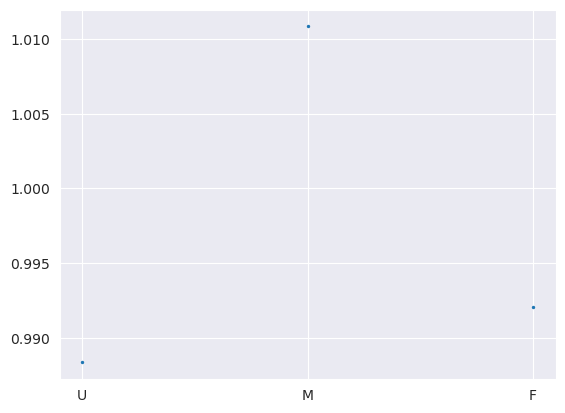

--- Chi Square GOF ---
(requires equal scaling)
p = 0.10989880648908609
same


--- Kullback Leibler Divergence ---
(does not depend on scaling)
D = 6.381922810710086e-05 

--- Rank Correlation Coefficient ---
(does not depend on scaling, only order)
SpearmanrResult(correlation=1.0, pvalue=0.0)
same




<Figure size 640x480 with 0 Axes>

In [77]:
e = df.GENDER.value_counts().sort_values(ascending=False)
o = df_res.GENDER.value_counts().sort_values(ascending=False)
make_all_tests(e, o, "GENDER")

### Sort by value ###
--- Visual Comparison (equally scaled) ---
1. Plot both


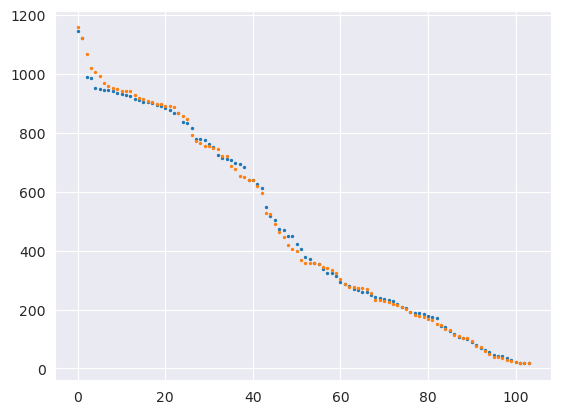

2. Plot total difference


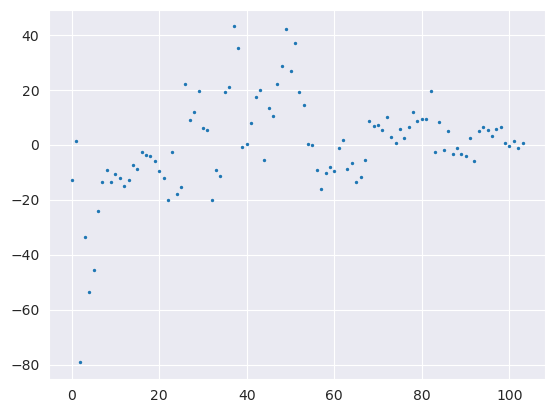

3. mean diff = -2.3229281746003276e-15 

4. Plot ratio e to o


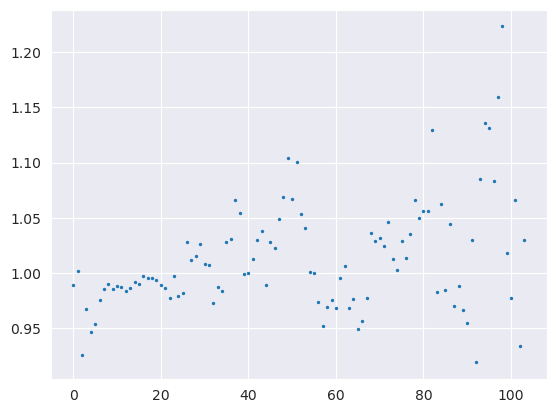

--- Chi Square GOF ---
(requires equal scaling)
p = 0.9999641411398001
same


--- Kullback Leibler Divergence ---
(does not depend on scaling)
D = 0.0008158031730622347 

--- Rank Correlation Coefficient ---
(does not depend on scaling, only order)
SpearmanrResult(correlation=0.9999893309576932, pvalue=4.823796910756195e-240)
same


### Sort by Index ###
--- Visual Comparison (equally scaled) ---
1. Plot both


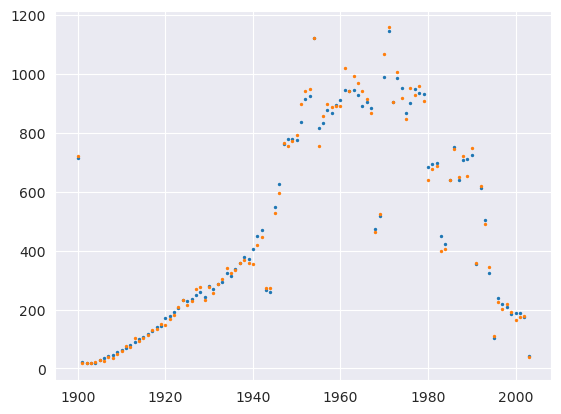

2. Plot total difference


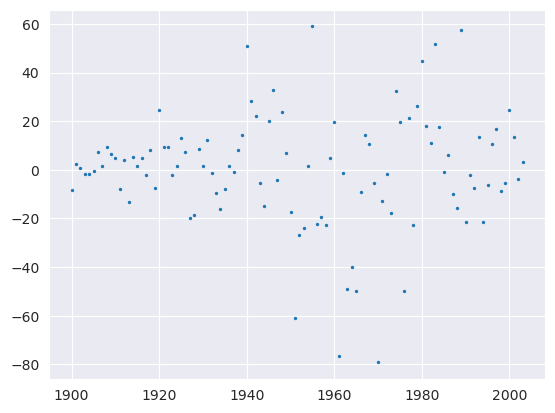

3. mean diff = -2.3229281746003276e-15 

4. Plot ratio e to o


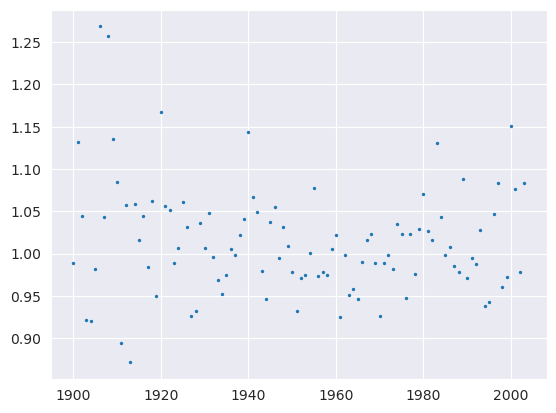

--- Chi Square GOF ---
(requires equal scaling)
p = 0.5852463467969237
same


--- Kullback Leibler Divergence ---
(does not depend on scaling)
D = 0.0014595672413687765 

--- Rank Correlation Coefficient ---
(does not depend on scaling, only order)
SpearmanrResult(correlation=0.9962871683398807, pvalue=1.8386615947426166e-110)
same




<Figure size 640x480 with 0 Axes>

In [78]:
e = df.YEAROFBIRTH.value_counts().sort_values(ascending=False)
o = df_res.YEAROFBIRTH.value_counts().sort_values(ascending=False)
make_all_tests(e, o, "YEAROFBIRTH")

### Sort by value ###
--- Visual Comparison (equally scaled) ---
1. Plot both


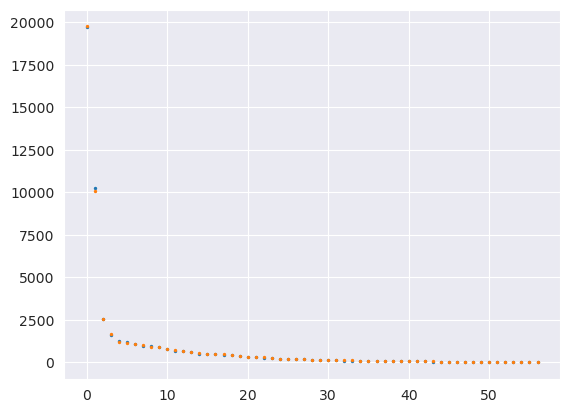

2. Plot total difference


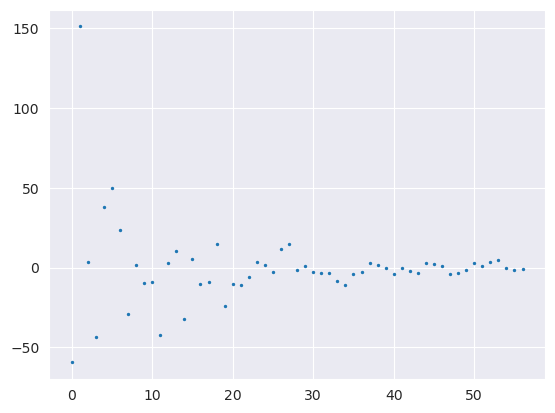

3. mean diff = -4.612294951425212e-15 

4. Plot ratio e to o


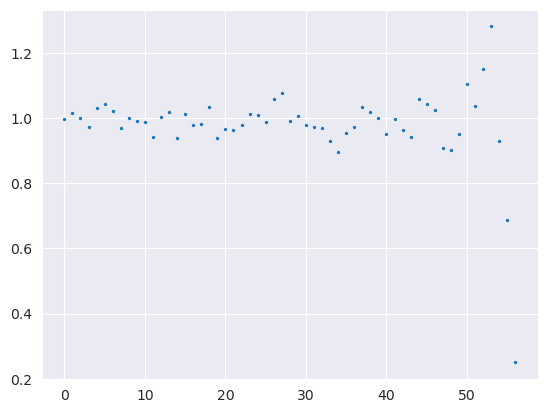

--- Chi Square GOF ---
(requires equal scaling)
p = 0.9995936107636902
same


--- Kullback Leibler Divergence ---
(does not depend on scaling)
D = 0.00036852998487991404 

--- Rank Correlation Coefficient ---
(does not depend on scaling, only order)
SpearmanrResult(correlation=0.9999351806837757, pvalue=1.3477892055999411e-108)
same


### Sort by Index ###
--- Visual Comparison (equally scaled) ---
1. Plot both


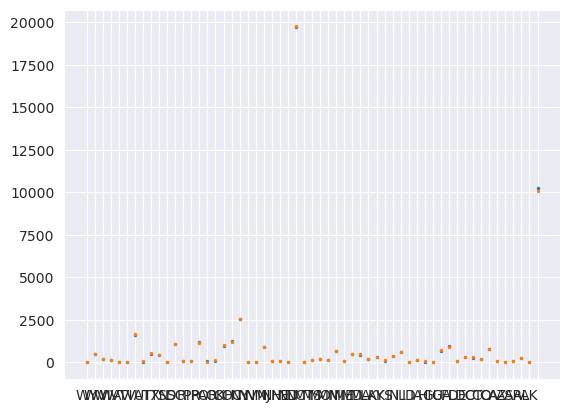

2. Plot total difference


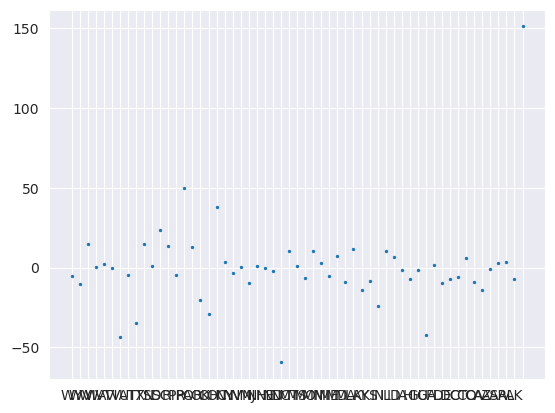

3. mean diff = -4.487638331116422e-15 

4. Plot ratio e to o


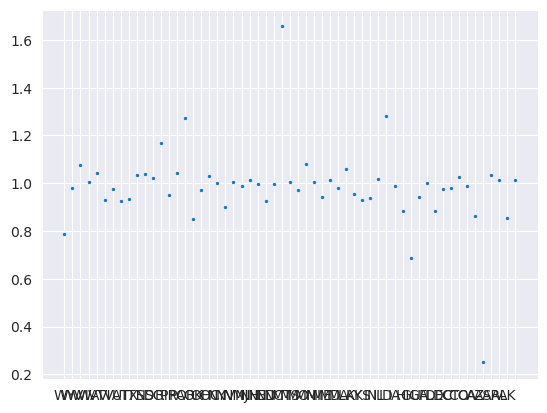

--- Chi Square GOF ---
(requires equal scaling)
p = 0.8245756101206613
same


--- Kullback Leibler Divergence ---
(does not depend on scaling)
D = 0.0006597274650560872 

--- Rank Correlation Coefficient ---
(does not depend on scaling, only order)
SpearmanrResult(correlation=0.9967589312442903, pvalue=6.823806509286968e-62)
same




<Figure size 640x480 with 0 Axes>

In [79]:
e = df.PLACEOFBIRTH.value_counts().sort_values(ascending=False)
o = df_res.PLACEOFBIRTH.value_counts().sort_values(ascending=False)
make_all_tests(e, o, "PLACEOFBIRTH")

### Sort by value ###
--- Visual Comparison (equally scaled) ---
1. Plot both


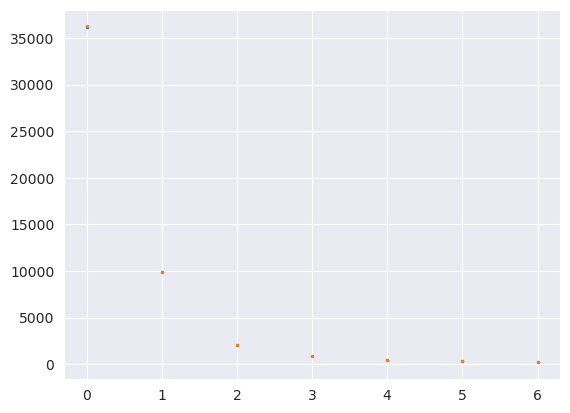

2. Plot total difference


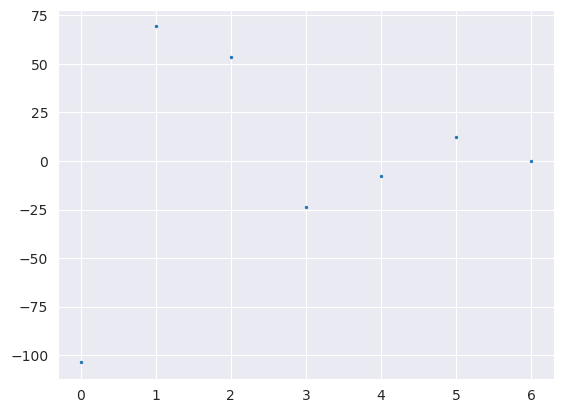

3. mean diff = -5.684341886080802e-14 

4. Plot ratio e to o


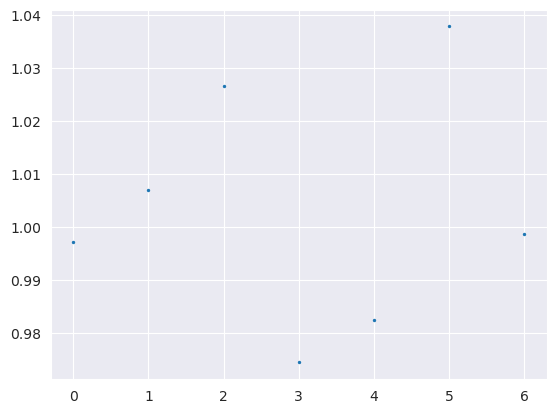

--- Chi Square GOF ---
(requires equal scaling)
p = 0.761062435545909
same


--- Kullback Leibler Divergence ---
(does not depend on scaling)
D = 4.899403755810868e-05 

--- Rank Correlation Coefficient ---
(does not depend on scaling, only order)
SpearmanrResult(correlation=1.0, pvalue=0.0)
same


### Sort by Index ###
--- Visual Comparison (equally scaled) ---
1. Plot both


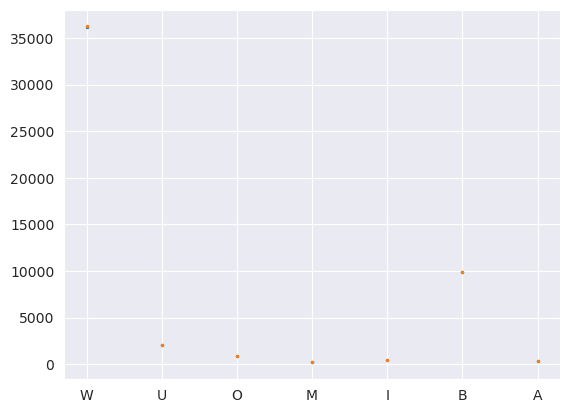

2. Plot total difference


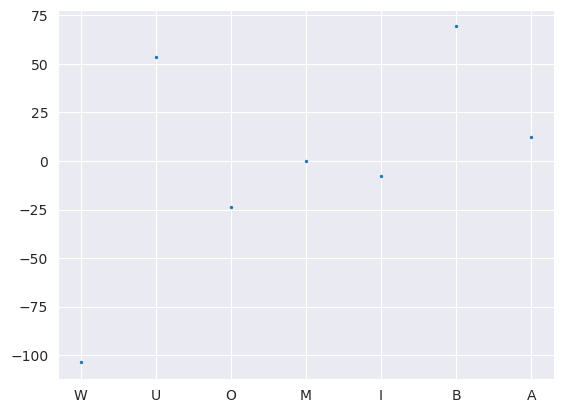

3. mean diff = -5.684341886080802e-14 

4. Plot ratio e to o


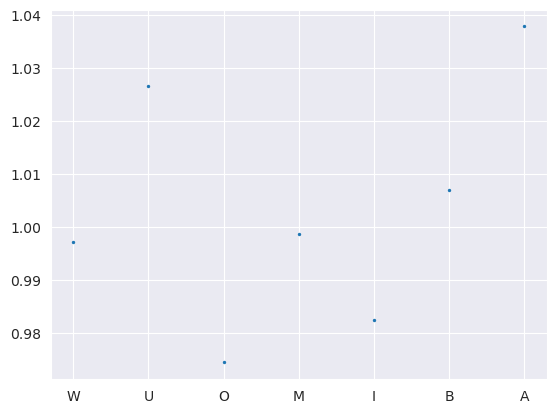

--- Chi Square GOF ---
(requires equal scaling)
p = 0.761062435545909
same


--- Kullback Leibler Divergence ---
(does not depend on scaling)
D = 4.899403755810855e-05 

--- Rank Correlation Coefficient ---
(does not depend on scaling, only order)
SpearmanrResult(correlation=1.0, pvalue=0.0)
same




<Figure size 640x480 with 0 Axes>

In [80]:
e = df.RACE.value_counts().sort_values(ascending=False)
o = df_res.RACE.value_counts().sort_values(ascending=False)
make_all_tests(e, o, "RACE")

In [81]:
from error_rates import get_all_errors

### Sort by value ###
--- Visual Comparison (equally scaled) ---
1. Plot both


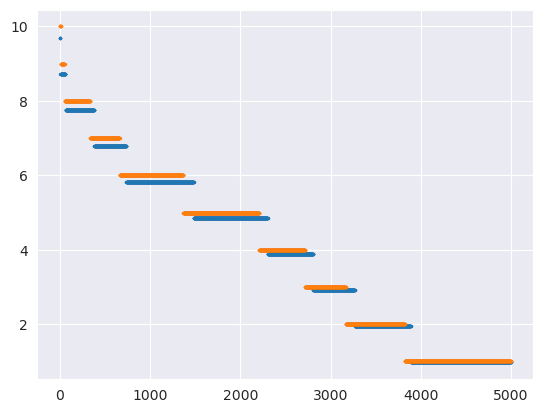

2. Plot total difference


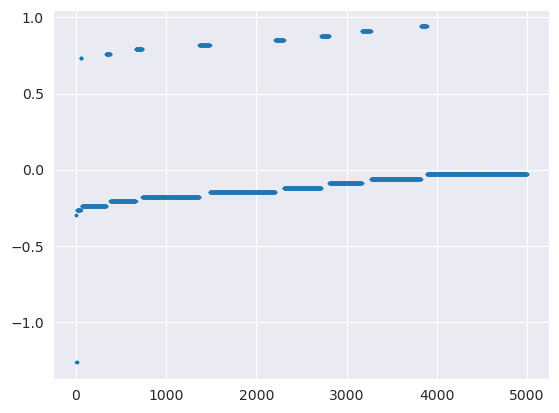

3. mean diff = 2.2737367544323207e-17 

4. Plot ratio e to o


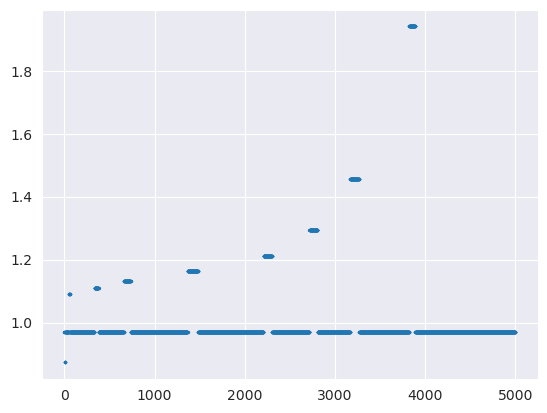

--- Chi Square GOF ---
(requires equal scaling)
p = 1.0
same


--- Kullback Leibler Divergence ---
(does not depend on scaling)
D = 0.006042083018074769 

--- Rank Correlation Coefficient ---
(does not depend on scaling, only order)
SpearmanrResult(correlation=0.9896438623711143, pvalue=0.0)
same


### Sort by Index ###
--- Visual Comparison (equally scaled) ---
1. Plot both


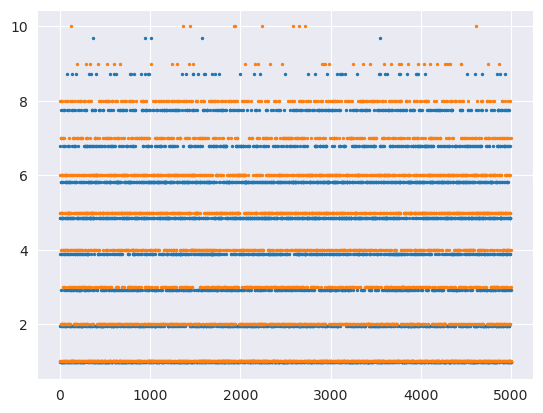

2. Plot total difference


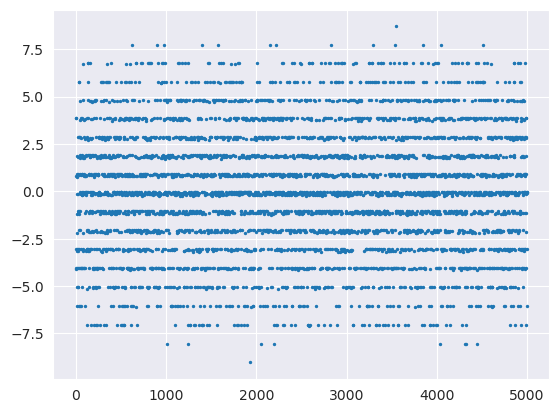

3. mean diff = 7.105427357601002e-18 

4. Plot ratio e to o


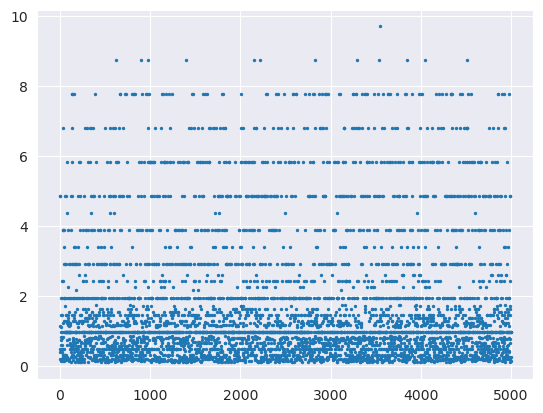

--- Chi Square GOF ---
(requires equal scaling)
p = 0.0
different


--- Kullback Leibler Divergence ---
(does not depend on scaling)
D = 0.598575884978892 

--- Rank Correlation Coefficient ---
(does not depend on scaling, only order)
SpearmanrResult(correlation=-0.008318507983070813, pvalue=0.5564850097432693)
different




<Figure size 640x480 with 0 Axes>

In [82]:
measure = "count_errors"
e = get_all_errors(df, measure)
o = get_all_errors(df_res, measure)
make_all_tests(e, o, "ERROR-RATE")

Note: Sort by index not  meaningful with this error rate data
But we could do it with an error rate frequency distribution:

### Sort by value ###
--- Visual Comparison (equally scaled) ---
1. Plot both


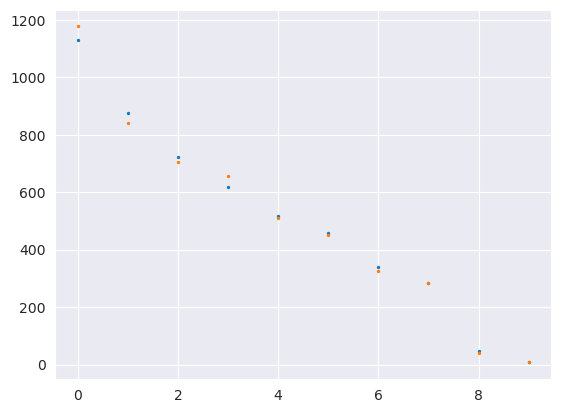

2. Plot total difference


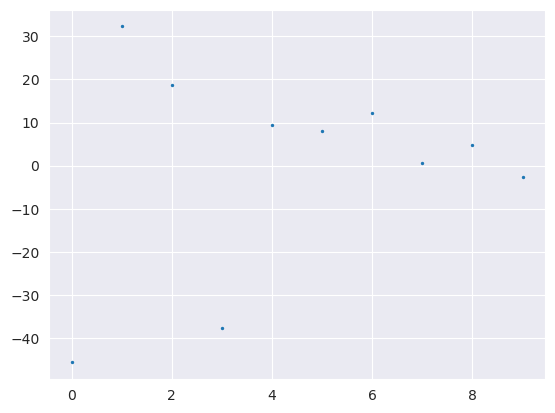

3. mean diff = -1.1901590823981678e-14 

4. Plot ratio e to o


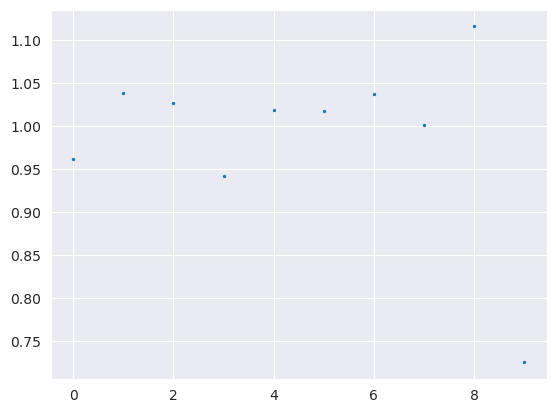

--- Chi Square GOF ---
(requires equal scaling)
p = 0.5214073283429943
same


--- Kullback Leibler Divergence ---
(does not depend on scaling)
D = 0.0011359281787978427 

--- Rank Correlation Coefficient ---
(does not depend on scaling, only order)
SpearmanrResult(correlation=0.9999999999999999, pvalue=6.646897422032013e-64)
same


### Sort by Index ###
--- Visual Comparison (equally scaled) ---
1. Plot both


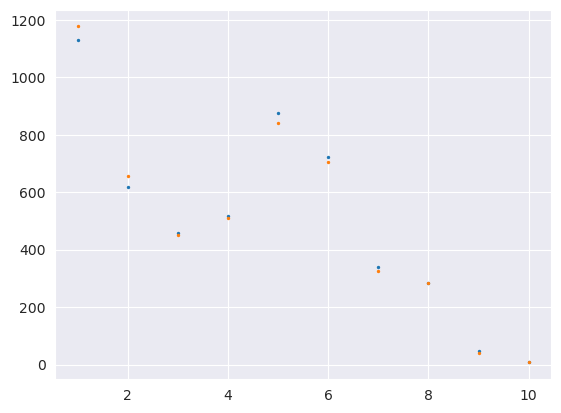

2. Plot total difference


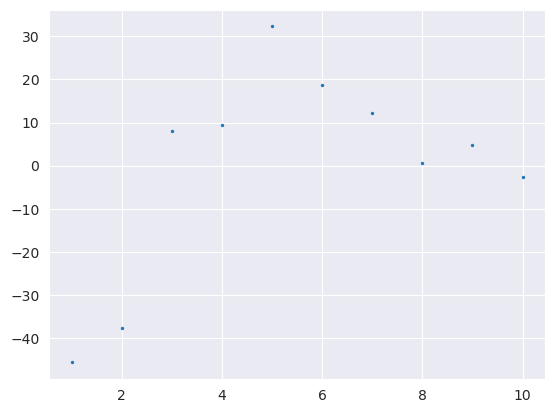

3. mean diff = -1.1368683772161604e-14 

4. Plot ratio e to o


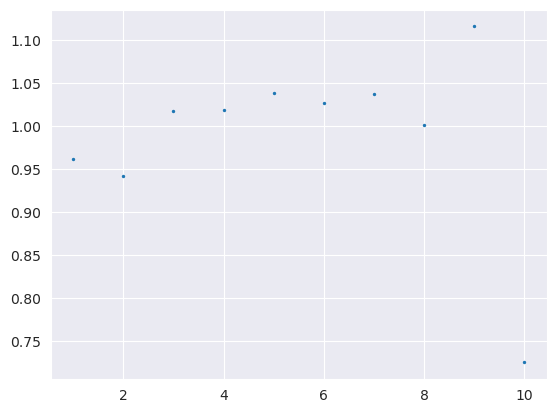

--- Chi Square GOF ---
(requires equal scaling)
p = 0.5214073283429943
same


--- Kullback Leibler Divergence ---
(does not depend on scaling)
D = 0.0011359281787978398 

--- Rank Correlation Coefficient ---
(does not depend on scaling, only order)
SpearmanrResult(correlation=0.9999999999999999, pvalue=6.646897422032013e-64)
same




<Figure size 640x480 with 0 Axes>

In [83]:
e = get_all_errors(df, measure).value_counts()
o = get_all_errors(df_res, measure).value_counts()
make_all_tests(e, o, "ERROR-RATE-DIST")